In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import utils

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 14

HL_THRESH = 15

patients = utils.get_patients(HL_THRESH)
ears_unf = utils.patients2ears(patients, HL_THRESH)

# drop patients without both air PTA and bone PTA
# NOTE: Must do this after the ears data set is generated
patients = patients.dropna(subset=['R Air PTA','L Air PTA'], how='any')

# ears = ears[ears['airpta'].notnull() & ears['bonepta'].notnull() & ears['airbonegap'].notnull()]
ears = ears_unf.query('airpta.notnull() and bonepta.notnull() and airbonegap.notnull()')

In [ ]:
# 100656 Left ear to be included for type of hearing loss and right for just yes/no hearing loss

In [2]:
def filter_some_nulls(patient):
  null_pct = patient[['L Air PTA','R Air PTA','R Bone PTA','L Bone PTA']].isnull().mean()
  return (null_pct.gt(0) & null_pct.lt(1)).any()

patients[patients.duplicated(['LCRC ID','BBDC ID'], keep=False)].sort_values(['LCRC ID','BBDC ID','VisitDate']).groupby(['LCRC ID','BBDC ID']).filter(filter_some_nulls)[[
  'LCRC ID','BBDC ID','VisitDate','DOB','L Air PTA','R Air PTA','R Bone PTA','L Bone PTA'
]].replace({'LCRC ID':-1,'BBDC ID':-1},np.nan)#.to_csv('partial_eval_patients.csv')

,LCRC ID,BBDC ID,VisitDate,DOB,L Air PTA,R Air PTA,R Bone PTA,L Bone PTA


In [5]:
patients[patients['BBDC ID']==152122][['L Air PTA','R Air PTA','L Bone PTA','R Bone PTA']]

,L Air PTA,R Air PTA,L Bone PTA,R Bone PTA
245,20.0,10.0,96.666667,100.0


In [16]:
patients[patients['LCRC ID']==100231][['LCRC ID','BBDC ID','R Air PTA','L Air PTA','L Bone PTA','R Bone PTA']]

,LCRC ID,BBDC ID,R Air PTA,L Air PTA,L Bone PTA,R Bone PTA
89,100231.0,-1.0,5.0,6.666667,5.0,0.0


In [ ]:
patients[patients.duplicated(['LCRC ID','BBDC ID'],keep=False)][['LCRC ID','BBDC ID','R Air PTA','L Air PTA','L Bone PTA','R Bone PTA']].sort_values(['LCRC ID','BBDC ID'])

In [130]:
patients[patients['consortium_ID']==100656]

,LCRC ID,BBDC ID,Age,Gender,VisitDate,DOB,Subtype of OI,L Air PTA,L Bone PTA,R Air PTA,R Bone PTA,consortium,consortium_ID,HL_sidedness,age_bin,UID
285,100656,-1,15.117808,Female,2011-07-19,1996-06-09,IV,16.666667,15.0,16.666667,NaN,LCRC,100656,none,10.0,285


In [131]:
ears[ears['consortium_ID']==100656]

variable,UID,Gender,VisitDate,Subtype of OI,Age,age_bin,consortium,consortium_ID,side,airpta,bonepta,airbonegap,HL_type,CHL,SNHL,MHL
570,285,Female,2011-07-19,IV,15.117808,10.0,LCRC,100656,Left,16.666667,15.0,1.666667,NaN,False,False,False


In [5]:
patients['Subtype of OI'].unique()

array(['IV', 'III', 'I', 'V', 'VIII'], dtype=object)

In [6]:
patients[['LCRC ID','BBDC ID']].to_csv('patients_filtered_ids.csv', index=False)

In [10]:
ears.merge(patients[['LCRC ID','BBDC ID','UID']],on='UID')[['LCRC ID','BBDC ID']].to_csv('ears_filtered_ids.csv', index=False)

In [6]:
def fmt_age(i, n=None, prefix=None):
  s = ''
  if i == 0: s = '< 10 y.'
  elif i == -1: s = 'No Age Data'
  elif i == 60: s = '$\geq$ 60 y.'
  else: s = f'{i} - {i+9} y.'
  if prefix: s = prefix + ' ' + s
  if n is not None: s += f'\n(n={n[i]})'
  return s

def get_freq_table(data, by):
  table = pd.concat([
    patients[by].value_counts().rename('Total Patients').to_frame().T,
    pd.crosstab(data['Gender'], data[by]),
    pd.crosstab(data['age_bin'], data[by]).rename(index=fmt_age),
    pd.crosstab('Subtype '+data['Subtype of OI'], data[by])
  ],sort=False).sort_index(axis=1)
  return table.assign(All = table.sum(1)) # add column totals

# print('FOR HEARING LOSS',HL_THRESH)
# print(get_freq_table(patients, 'consortium').to_latex())
# print(get_freq_table(patients, 'HL_sidedness').to_latex())

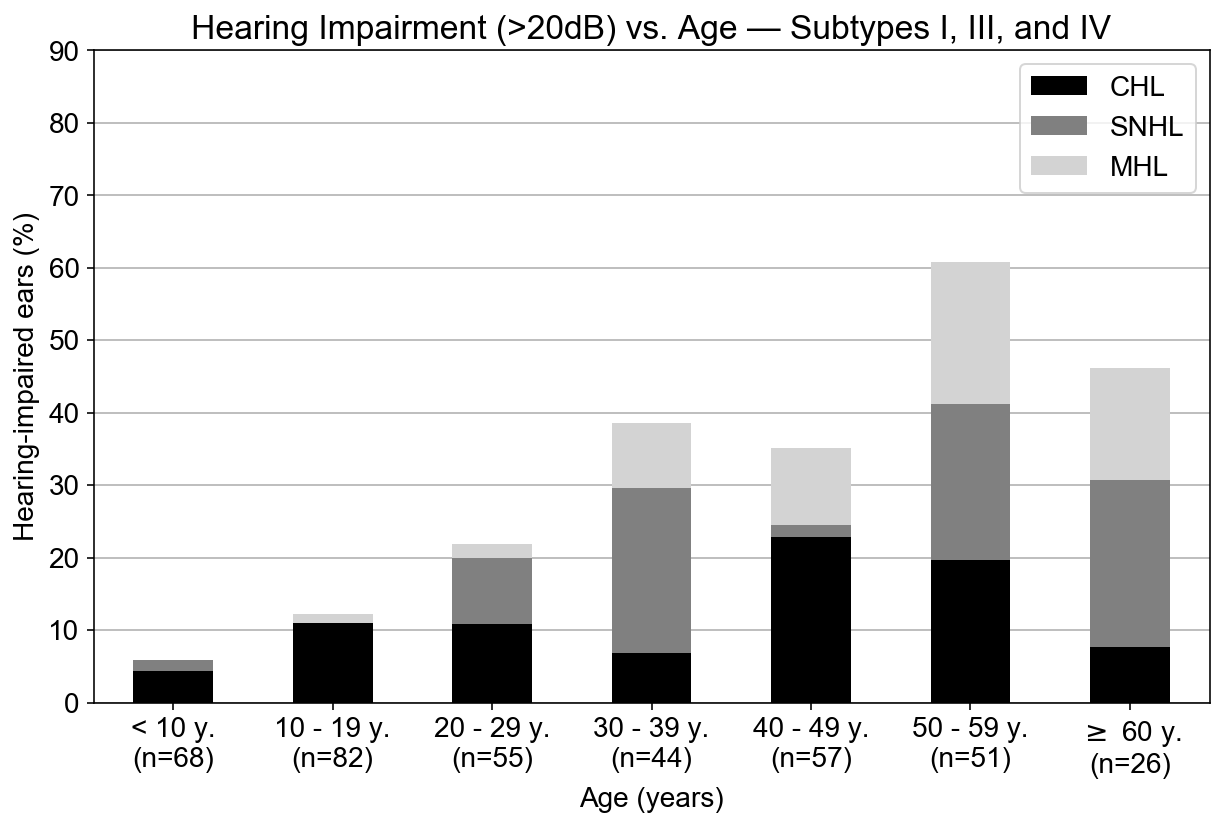

In [25]:
n = ears.age_bin.value_counts() # for x axis labeling
p = ears.groupby('age_bin')[['CHL','SNHL','MHL']].mean().rename(index=lambda i: fmt_age(i,n))
ax = p.mul(100).plot.bar(figsize=(10,6), rot=0, stacked=True, color=['black','grey','lightgrey'])
ax.legend(title=None)
ax.grid(axis='y')
ax.set_axisbelow(True) # hides grid behind bars
ax.set_ylabel('Hearing-impaired ears (%)')
ax.set_title(f'Hearing Impairment (>{HL_THRESH}dB) vs. Age')
# ax.set_title(f'Hearing Impairment (>{HL_THRESH}dB) vs. Age — Subtypes I, III, and IV')
ax.set_xlabel('Age (years)')
ax.set_ylim((0,90));

['< 10 y.',
 '10 - 19 y.',
 '20 - 29 y.',
 '30 - 39 y.',
 '40 - 49 y.',
 '50 - 59 y.',
 '$\\geq$ 60 y.']

In [67]:
tmp = ears[ears['HL_type']=='MHL']
tmp = pd.crosstab(tmp['age_bin'], tmp['severity'], margins=True)
tmp.index = tmp.index[:-1].map(fmt_age).tolist() + ['All']
tmp.reindex(
  index=list(map(fmt_age, range(0,61,10))) + ['All'],
  columns=['mild','moderate','severe','All']).fillna(0).astype(int)

severity,mild,moderate,severe,All
< 10 y.,0,0,0,0
10 - 19 y.,0,0,0,1
20 - 29 y.,1,0,0,1
30 - 39 y.,1,1,2,4
40 - 49 y.,1,1,1,6
50 - 59 y.,0,7,2,10
$\geq$ 60 y.,0,3,1,4
All,3,12,6,26


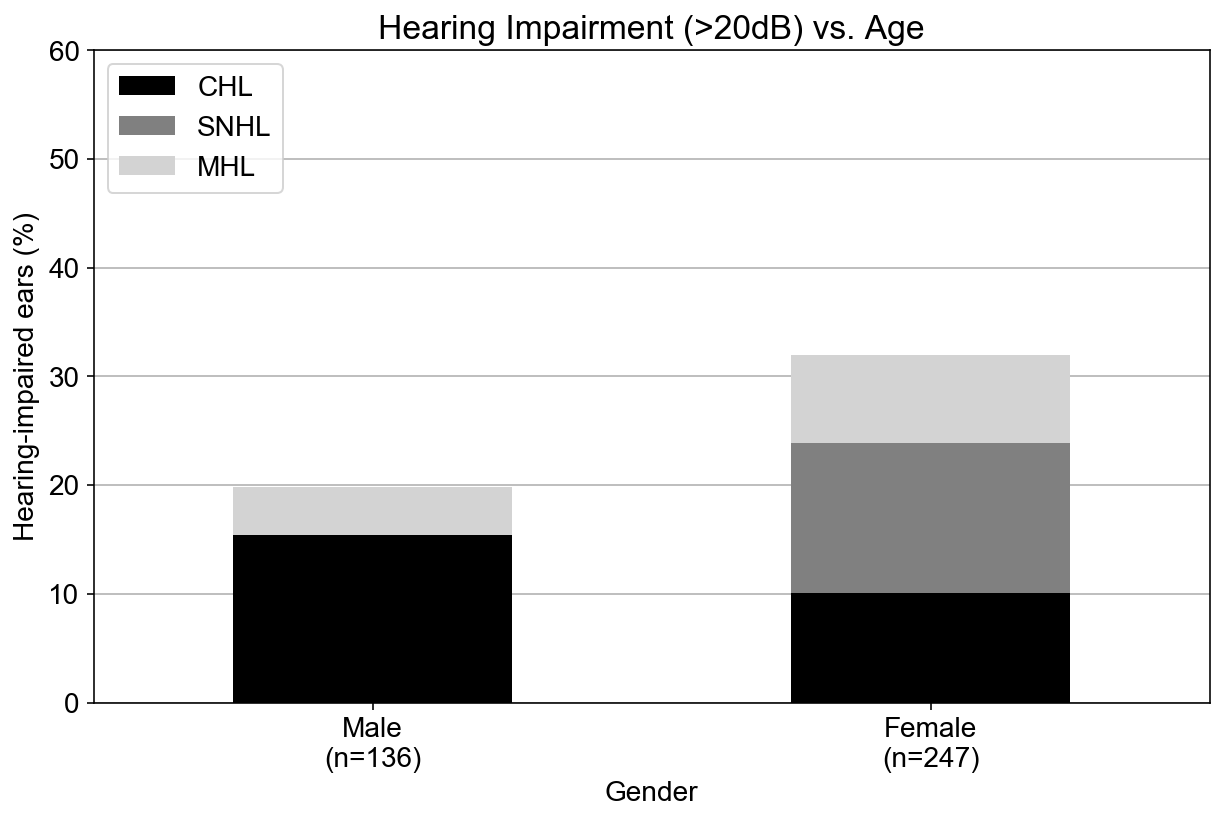

In [41]:
p = ears[~ears['Subtype of OI'].isin(['V','VIII'])].groupby('Gender')[['CHL','SNHL','MHL']].mean()
n = ears[~ears['Subtype of OI'].isin(['V','VIII'])].Gender.value_counts()
p.index = p.index.map(lambda i: f'{i}\n(n={n[i]})')
p.sort_index(ascending=False,inplace=True)
ax = p.mul(100).plot.bar(figsize=(10,6), rot=0, stacked=True, color=['black','grey','lightgrey'])
ax.legend(title=None,loc='upper left')
ax.grid(axis='y')
ax.set_axisbelow(True) # hides grid behind bars
ax.set_ylabel('Hearing-impaired ears (%)')
ax.set_title(f'Hearing Impairment (>{HL_THRESH}dB) vs. Age')
ax.set_xlabel('Gender')
ax.set_ylim((0,60));

In [35]:
def plot_subtype(data, subtype):
  d = data[data['Subtype of OI']==subtype]
  p = d.groupby('age_bin')[['CHL','SNHL','MHL']].mean().reindex(data.age_bin.unique()).fillna(0).sort_index()
  n = d.age_bin.value_counts().reindex(data.age_bin.unique()).fillna(0).astype(int)
  p.index = p.index.map(lambda i: fmt_age(i,n))
  ax = p.mul(100).plot.bar(figsize=(10,6), rot=0, stacked=True, color=['black','grey','lightgrey'])
  ax.legend(title=None)
  ax.grid(axis='y')
  ax.set_axisbelow(True) # hides grid behind bars
  ax.set_ylabel('Hearing-impaired ears (%)')
  ax.set_title(f'OI Subtype {subtype}: Hearing Impairment (>{HL_THRESH}dB) vs. Age');
  ax.set_xlabel('Age (years)')
  ax.set_ylim((0,90));

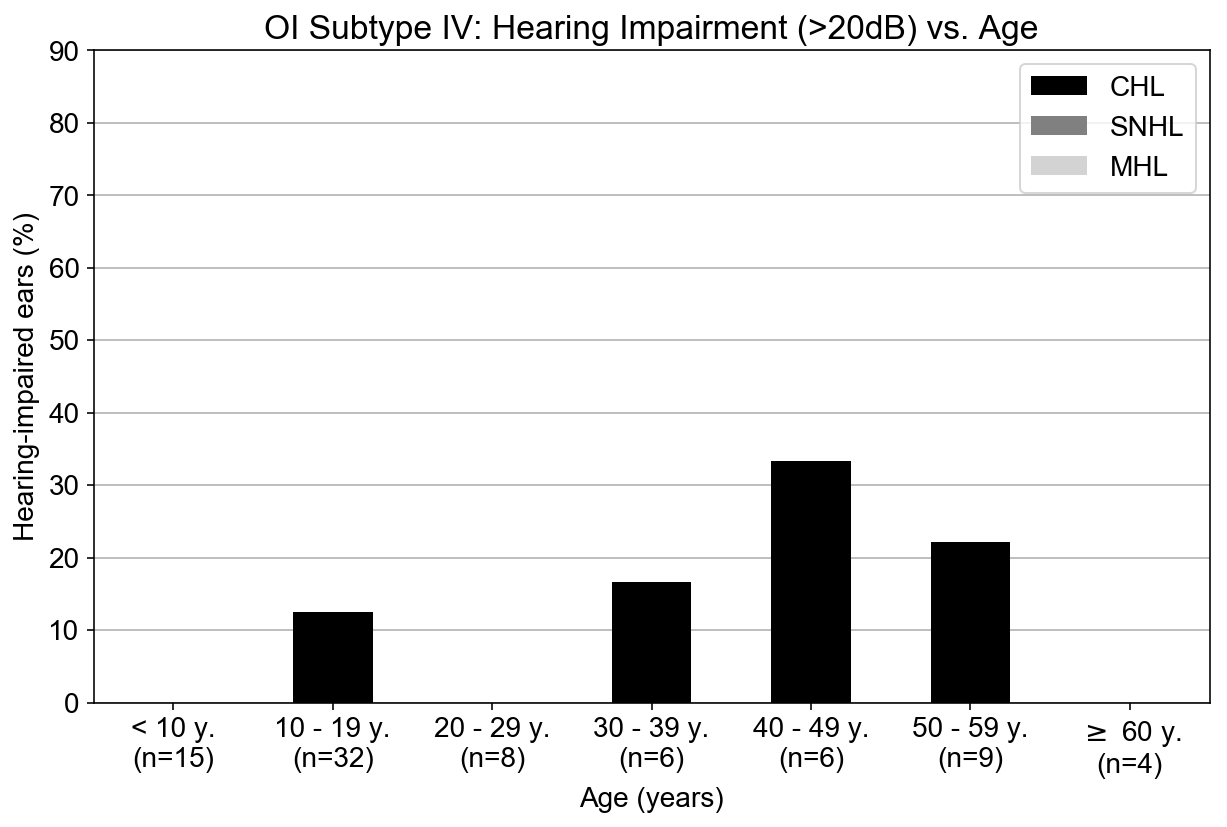

In [38]:
plot_subtype(ears, 'IV')

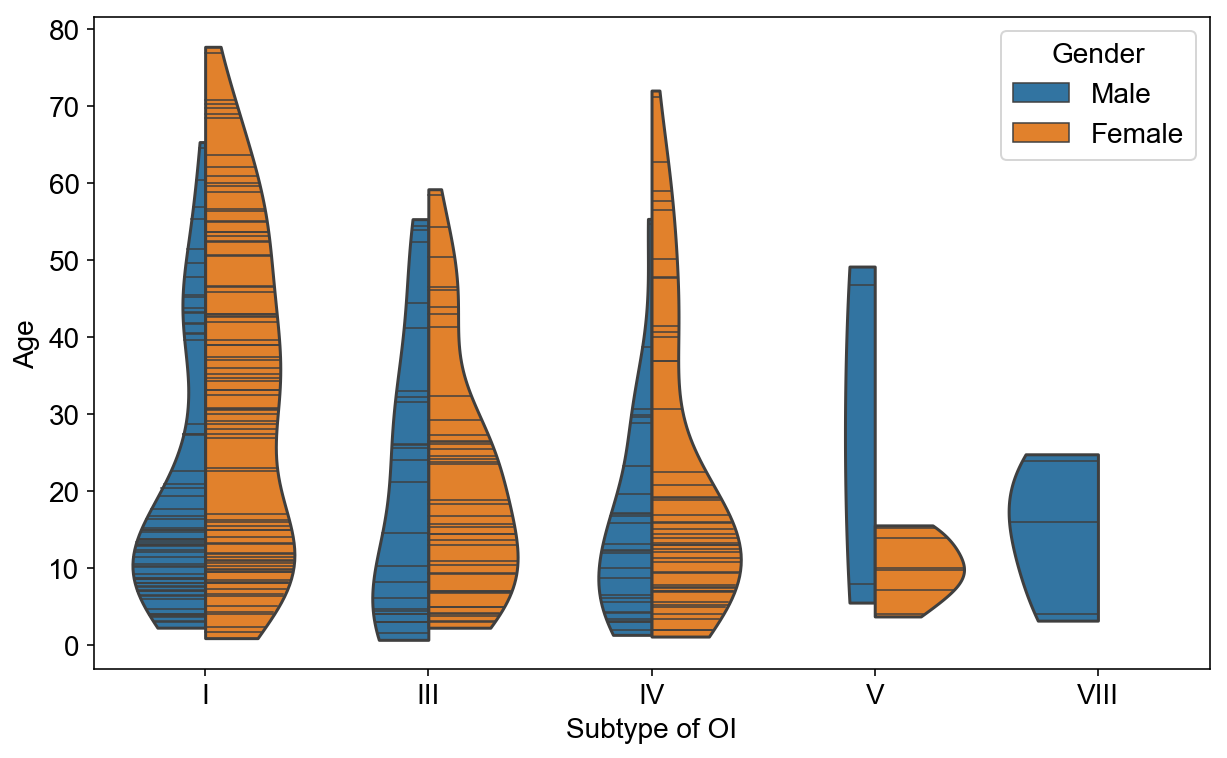

In [6]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.violinplot(x='Subtype of OI', y='Age', hue='Gender', split=True, scale='count', data=patients,
               order=['I','III','IV','V','VIII'],scale_hue=True,inner='stick',cut=.1);
# sns.swarmplot(x='Subtype of OI', y='Age', hue='Gender', data=patients, order=['I','III','IV','V','VIII'],dodge=True)
# sns.stripplot(x='Subtype of OI', y='Age', hue='Gender', data=patients)

In [25]:
import statsmodels.api as sm
y = ears[(ears.airpta>HL_THRESH)&(ears['Subtype of OI'].isin(['I','III','IV']))].airpta.apply(np.log)
x = pd.get_dummies(ears.loc[y.index, ['Age','Gender','Subtype of OI']], drop_first=True)
lr = sm.OLS(y, sm.add_constant(x)).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 airpta   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.394
Date:                Mon, 28 Jan 2019   Prob (F-statistic):              0.241
Time:                        18:37:01   Log-Likelihood:                -60.681
No. Observations:                 106   AIC:                             131.4
Df Residuals:                     101   BIC:                             144.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.3566      0.144     23.247      0.000       3.070       3.643
Age                   0.0059      0.003      2.121      0.036       0.000       0.011
Gender_Male           0.0204      0.100      0.203      0.839      -0.178       0.219
Subtype of OI_III     0.1164      0.114      1.018      0.311      -0.111       0.343
Subtype of OI_IV     -0.0505      0.160     -0.315      0.753      -0.368       0.268
==============================================================================
Omnibus:                        7.571   Durbin-Watson:                   1.842
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.961
Skew:                           0.652   Prob(JB):                       0.0187
Kurtosis:                       2.676   Cond. No.                         198.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

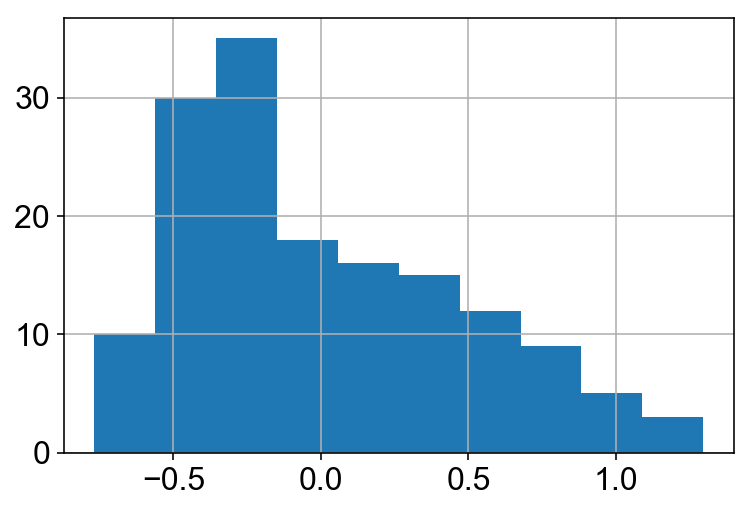

In [21]:
lr.resid.hist()

In [11]:
# Hearing loss by gender
import scipy.stats as sp
table = pd.crosstab(ears.airpta>HL_THRESH, ears.Gender)
chi2, p, dof, exp = sp.chi2_contingency(table)
assert table.ge(5).all().all() and (exp>=5).all()
print(HL_THRESH)
print('chi-square p val:',p)
odds, p = sp.fisher_exact(table)
print('fisher p val:',p)

20
chi-square p val: 0.02708530006109678
fisher p val: 0.024723278578396523


In [12]:
# type of hearing loss by gender
# table = pd.crosstab(ears.Gender, ears[['CHL','SNHL','MHL']].idxmax(1))
table = pd.crosstab(ears.Gender, ears.SNHL)
chi2, p, dof, exp = sp.chi2_contingency(table, correction=False)
print(HL_THRESH)
print('chi-square p val:',p)
assert table.ge(5).all().all() and (exp>=5).all()

20
chi-square p val: 3.873746011411476e-06


AssertionError: 

In [13]:
odds, p = sp.fisher_exact(table)
print('fisher p val:',p)

fisher p val: 1.0224164450565223e-07


In [27]:
pd.crosstab(ears_unf['Subtype of OI'], ears_unf.HL_type)

HL_type,CHL,MHL,SNHL
Subtype of OI,,,
I,28,26,47
III,19,4,11
IV,11,2,5
V,0,0,2
VIII,0,2,0


In [21]:
pd.concat([
  pd.crosstab(ears_unf['Subtype of OI'], ears_unf['airpta'].notnull())[True],
  pd.crosstab(ears_unf['Gender'], ears_unf['airpta'].notnull())[True]
]).set_value('Total',ears_unf['airpta'].notnull().sum()).rename('Ears with air PTA').to_frame().join(
pd.concat([
  pd.crosstab(ears_unf['Subtype of OI'], ears_unf.eval('airpta.notnull() and bonepta.notnull()'))[True],
  pd.crosstab(ears_unf['Gender'], ears_unf.eval('airpta.notnull() and bonepta.notnull()'))[True]
]).set_value('Total',ears_unf.eval('airpta.notnull() and bonepta.notnull()').sum()).rename('Ears with air and bone PTA')
).join(
pd.concat([
  pd.crosstab(ears_unf['Subtype of OI'], ears_unf['airpta'].gt(20))[True],
  pd.crosstab(ears_unf['Gender'], ears_unf['airpta'].gt(20))[True],
]).set_value('Total', ears_unf['airpta'].gt(20).sum()).rename('Ears with airpta>20')).join(
pd.concat([
  ears_unf[['CHL','SNHL','MHL']].sum().rename('Total').to_frame().T,
  pd.crosstab(ears_unf['Subtype of OI'], ears_unf['HL_type']),
  pd.crosstab(ears_unf['Gender'], ears_unf['HL_type']),
])).join(
pd.concat([
  pd.crosstab(ears_unf['Subtype of OI'], ears_unf['severity']),
  pd.crosstab(ears_unf['Gender'], ears_unf['severity']),
]).append(ears_unf['severity'].value_counts().rename('Total')))

/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  after removing the cwd from sys.path.
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/Users/Jake/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silenc

,Ears with air PTA,Ears with air and bone PTA,Ears with airpta>20,CHL,MHL,SNHL,mild,moderate,profound,severe
I,313,220,81,26,22,28,49,21,5,6
III,142,83,28,11,4,6,19,6,1,2
IV,150,80,23,9,0,0,20,3,0,0
V,16,2,1,0,0,1,1,0,0,0
VIII,6,2,4,2,0,0,2,2,0,0
Female,366,249,91,25,20,35,58,22,4,7
Male,261,138,46,23,6,0,33,10,2,1
Total,627,387,137,48,26,35,91,32,6,8


In [39]:
# Out of the patients with types I,III and IV - 
# Can you tell me the mean and median age for patients with Hearing loss(all types) / CHL / SNHL / MHL / SNHL+MHL?
print('FOR HL',HL_THRESH)
ears_unf[ears_unf['Subtype of OI'].isin(['I','III','IV'])].groupby('HL_type')['Age'].agg(['mean','median'])\
.append(ears_unf[ears_unf['Subtype of OI'].isin(['I','III','IV']) & ears_unf['HL_type'].isin(['SNHL','MHL'])]['Age'].apply(['mean','median']).rename('SNH+MHL'))

FOR HL 15


,mean,median
HL_type,,
CHL,30.236267,26.402740
MHL,47.139041,48.595890
SNHL,45.029441,45.463014
SNH+MHL,45.740043,45.463014


In [52]:
# For type III OI subgroup <10 years of age - hearing loss is more than 25%.
# Can we find a p value for that when compared to the prevalence of HL in the same age group with OI type I?
from statsmodels.stats.proportion import proportions_ztest
proportions_ztest(
  count=[
    ears[(ears['Subtype of OI']=='III') & (ears['Age']<10)]['HL_type'].notnull().sum(),
    ears[(ears['Subtype of OI']=='I') & (ears['Age']<10)]['HL_type'].notnull().sum(),
  ],
  nobs=[
    len(ears[(ears['Subtype of OI']=='III') & (ears['Age']<10)]),
    len(ears[(ears['Subtype of OI']=='I') & (ears['Age']<10)])
  ], alternative='larger'
)

(3.6007982258449123, 0.00015862085539031942)

In [79]:
def f(i):
  if len(i) == 2:
    return '+'.join(sorted(i))
  
ears.dropna(subset=['HL_type']).groupby('UID')['HL_type'].apply(f).value_counts().rename('count').to_frame()

,count
SNHL+SNHL,21
CHL+CHL,11
MHL+SNHL,9
MHL+MHL,8
CHL+SNHL,7
CHL+MHL,6
